In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [3]:
import fastai

In [4]:
matplotlib.rc('image', cmap="Greys_r")

In [5]:
from pathlib import *
from functools import partial

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [47]:
path = Path('/storage/data/mnist_sample/')
Path.BASE_PATH = path
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [48]:
train = path/'train'
valid = path/'valid'
train.ls(), valid.ls()

((#2) [Path('train/3'),Path('train/7')],
 (#2) [Path('valid/3'),Path('valid/7')])

In [49]:
# Training paths
threes_train_f = train/'3'
seven_train_f = train/'7'

# validation paths
threes_valid_f = valid/'3'
seven_valid_f = valid/'7'

<AxesSubplot:>

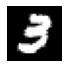

In [50]:
show_image(tensor(Image.open(threes_train_f.ls()[0])))

In [51]:
# Get all images
threes_train = torch.stack([tensor(Image.open(x)) for x in threes_train_f.ls().sorted()]).float()/255
seven_train = torch.stack([tensor(Image.open(x)) for x in seven_train_f.ls().sorted()]).float()/255

In [52]:
# Get all validation images
threes_valid = torch.stack([tensor(Image.open(x)) for x in threes_valid_f.ls()]).float()/255
seven_valid = torch.stack([tensor(Image.open(x)) for x in seven_valid_f.ls()]).float()/255

(torch.Size([6131, 28, 28]), <AxesSubplot:>)

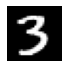

In [53]:
threes_train.shape, show_image(threes_train[1])

(<AxesSubplot:>, <AxesSubplot:>)

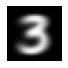

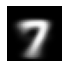

In [54]:
threes_mean = threes_train.mean(0)
sevens_mean = seven_train.mean(0)
show_image(threes_mean), show_image(sevens_mean)

In [55]:
def l1_dist(t): return (t - threes_mean).abs().mean()
print( f'l1 dist. sevens = {l1_dist(seven_train[0])}, threes = {l1_dist(threes_train[0])}')

def l2_dist(t): return (t - threes_mean).square().mean().sqrt()
print( f'l2 dist. sevens = {l2_dist(seven_train[0])}, threes = {l2_dist(threes_train[0])}')

l1 dist. sevens = 0.1715536266565323, threes = 0.10742203146219254
l2 dist. sevens = 0.30306190252304077, threes = 0.19120194017887115


In [56]:
def rmse_loss(t, mean): return (t - mean).square().mean((-2,-1)).sqrt()

def is_3(t): return rmse_loss(t, threes_mean) < rmse_loss(t, sevens_mean)

In [57]:
train_xs = torch.cat( (threes_train, seven_train) )
train_preds = is_3(train_xs)
train_xs.shape, train_preds.shape

(torch.Size([12396, 28, 28]), torch.Size([12396]))

In [58]:
def get_ys(shape, bool_val): return tensor(bool_val).expand(shape)

train_ys = torch.cat( [get_ys(threes_train.shape[0], True), get_ys(seven_train.shape[0], False)])
train_ys, train_ys.shape

(tensor([ True,  True,  True,  ..., False, False, False]), torch.Size([12396]))

In [59]:
def accuracy(preds, labels):
    correct = (preds>0.5) == labels
    return correct.float().mean()

accuracy(tensor(0.7), tensor(False))

tensor(0.)

In [60]:
valid_xs = torch.cat([threes_valid, seven_valid])
valid_preds = is_3(valid_xs)

valid_ys = torch.cat( [get_ys(threes_valid.shape[0], True), get_ys(seven_valid.shape[0], False)]).unsqueeze(1)

valid_ys.shape, valid_xs[0].mean()

(torch.Size([2038, 1]), tensor(0.1919))

## SGD

Stochastic gradient descent

We're trying to predict `3` or `7`. We can imagine a prediction function that will give a score. We can say that `3` is `1.0` and `7` is `0.` to reframe the binary classification problem. Thus, if the prediction is greater than 0.5, it's a `3` otherwise it's a `7`. Based on the distance, we assign a loss.

We guess function of the form: `y = ax + b`.

Need to find the right `a` and `b`. Calc gradient to change `a`

In [61]:
def loss(actuals, preds):
    return (preds.float() - actuals.float()).abs().mean()

In [62]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

mnist_loss(tensor(0.3), tensor(1.))

tensor(0.4256)

In [63]:
def init_params(size, seed=None, std=1.0):
    if seed is not None:
        torch.manual_seed(seed)
    else:
        torch.seed()
    return (torch.randn(size)*std).requires_grad_()

In [64]:
train_xs = train_xs.reshape((-1, 28 * 28))
train_xs.shape

torch.Size([12396, 784])

In [65]:
valid_xs = valid_xs.view((-1, 28 * 28))

In [66]:
def linear1(weights, bias, inputs):
    return torch.sigmoid(inputs@weights + bias)

In [67]:
def accuracy(preds, labels):
    correct = (preds>0.5) == labels
    return correct.float().mean()

def model_accuracy(model, xs, ys):
    preds = model(xs)
    return accuracy(preds, ys)

Matrix multiplication of weights and inputs (12396, 28 * 28). Shape of 'y' is 12396.


In [68]:
# Train 1 epoch

def train_epoch(dl, weights, bias, lr):
    for inputs,labels in dl:
        preds = linear1(weights, bias, inputs)
        l = mnist_loss(preds.float(), labels.float())
    #     print(f'loss = {l}')
        l.backward()

        with torch.no_grad():
            weights.data -= weights.grad * lr
            bias.data -= bias.grad * lr
    #         print(f'weights_init == weights, bias_init == bias = {torch.equal(weights_init, weights), torch.equal(bias_init, bias)}')

            weights.grad.zero_()
            bias.grad.zero_()

    return weights, bias

In [69]:
def create_dl(xs, ys):
    torch.manual_seed(42)
    return DataLoader(list(zip(xs, ys)), batch_size=256)

dl = create_dl(train_xs, train_ys)
f = first(dl)
f[0].mean(), f[1].float().mean()

(tensor(0.1472), tensor(1.))

#### Training ONE Epoch

In [70]:
weights = init_params((28 * 28, 1), seed=42)
bias = init_params(1, seed=42)

dl = create_dl(train_xs, train_ys)
lr = 1.
train_epoch(dl, weights, bias, lr)
first(dl)[0].mean(), model_accuracy(partial(linear1, weights, bias), valid_xs, valid_ys)


(tensor(0.1472), tensor(0.6658))

#### Training Multiple Epochs

In [71]:
def print_accuracy(weights, bias):
    train_accuracy = accuracy(linear1(weights, bias, train_xs), train_ys)
    valid_accuracy = accuracy(linear1(weights, bias, valid_xs), valid_ys)
    print(f'train accuracy = {train_accuracy}, valid accuracy = {valid_accuracy}')

In [72]:
def train_epochs(lr, inputs, labels):
    
    dl = DataLoader(list(zip(inputs, labels)), batch_size=256)
    
    weights = init_params((28 * 28, 1), seed=42)
    bias = init_params(1, seed=42)
    
    print_accuracy(weights, bias)

    for _ in range(21):
        train_epoch(dl, weights, bias, lr)
        print_accuracy(weights, bias)
    
    return (weights, bias)

In [73]:
final_weights, final_bias = train_epochs(1., train_xs, train_ys)

train accuracy = 0.5040044784545898, valid accuracy = 0.5456329584121704
train accuracy = 0.5028986930847168, valid accuracy = 0.6658488512039185
train accuracy = 0.5017519593238831, valid accuracy = 0.7801766395568848
train accuracy = 0.5010551810264587, valid accuracy = 0.8434739708900452
train accuracy = 0.5006967782974243, valid accuracy = 0.8709518909454346
train accuracy = 0.500484049320221, valid accuracy = 0.8900883197784424
train accuracy = 0.5003548860549927, valid accuracy = 0.9072620272636414
train accuracy = 0.5002772808074951, valid accuracy = 0.9195289611816406
train accuracy = 0.500240683555603, valid accuracy = 0.9278704524040222
train accuracy = 0.500217080116272, valid accuracy = 0.9317958950996399
train accuracy = 0.5002110004425049, valid accuracy = 0.9367026686668396
train accuracy = 0.5002232193946838, valid accuracy = 0.9411187171936035
train accuracy = 0.5002023577690125, valid accuracy = 0.9425907731056213
train accuracy = 0.5001927018165588, valid accuracy = 

#### Adding a Learner and using pytorch idioms to simplify what we did manually

In [74]:
w,b = nn.Linear(28*28, 4).parameters()
w.shape, b.shape

(torch.Size([4, 784]), torch.Size([4]))

In [75]:
train_dl = create_dl(train_xs, train_ys)
valid_dl = create_dl(valid_xs, valid_ys)
dls = DataLoaders(train_dl, valid_dl)

model = nn.Linear(28*28, 1)

learner = Learner(dls, model, loss_func=mnist_loss, opt_func=SGD, lr=1., metrics=accuracy)

In [76]:
learner.fit(n_epoch=21)

epoch,train_loss,valid_loss,accuracy,time
0,0.637268,0.501795,0.495584,00:00
1,0.313231,0.324950,0.608930,00:00
2,0.125592,0.160476,0.830716,00:00
3,0.061204,0.099966,0.900393,00:00
4,0.037092,0.074423,0.927380,00:00
5,0.027350,0.060362,0.941119,00:00
6,0.023108,0.051517,0.951914,00:00
7,0.021052,0.045555,0.956330,00:00
8,0.019898,0.041314,0.960255,00:00
9,0.019140,0.038159,0.965653,00:00


#### Adding Non-linearity and neural network

In [77]:
model = nn.Sequential(nn.Linear(28 * 28, 30), nn.ReLU(), nn.Linear(30,1))

In [78]:
learner = Learner(dls, model, loss_func=mnist_loss, opt_func=SGD, lr=1., metrics=accuracy)

In [79]:
learner.fit(21)

epoch,train_loss,valid_loss,accuracy,time
0,0.181939,0.491330,0.504416,00:00
1,0.095837,0.218973,0.766928,00:00
2,0.046969,0.115624,0.882237,00:00
3,0.029303,0.078532,0.920510,00:00
4,0.021739,0.062345,0.933268,00:00
5,0.018141,0.052594,0.944553,00:00
6,0.016190,0.046608,0.953386,00:00
7,0.014877,0.042937,0.954858,00:00
8,0.013932,0.040417,0.959274,00:00
9,0.013198,0.038484,0.961236,00:00


In [86]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=fastai.metrics.accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.092521,0.012846,0.995584,00:22


In [82]:
doc(cnn_learner)

1. How is a grayscale image represented on a computer? How about a color image?
    
    Matrix with an element for each pixel and the value of that pixel is represents how light or dark that pixel is. For a colour image, it could be done the same way with each pixel value being the hex value of the colour that it represents.


2. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?

   Separated by the digits and within each digit, there's a folder for training and another for validation. This makes it easy to do training and validation on each digit.


3. Explain how the "pixel similarity" approach to classifying digits works.

    Take the mean value of each pixel in the training set so that you can come up with a mean 3, a mean 7, etc. Then for any image, check the mean distance of the image from the mean 3 and mean 7 (mean 8, etc. if you're classifying those as well) to see if the image is closer to a `3` or a `7` and then classify it that way.


4. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.

   List comprehension in python is building a list from an iterable through a short-hand syntax as opposed to writing a for loop and pushing elements to the list in that fashion.


5. What is a "rank-3 tensor"?

    3 dim tensor


6. What is the difference between tensor rank and shape? How do you get the rank from the shape?

    Rank is number of dimensions. Shape is length of each dimension and therefore also tells the rank.


7. What are RMSE and L1 norm?

    Root Mean Square error is the mean ( sqrt( sum of squares of individual distances) ). l1 = mean ( sum of absolute value of individual distances )


8. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?

    By doing an operation on a an entire tensor such as tensor * 2. pytorch has optimized code that will run this on a gpu.


9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

    

10. What is broadcasting?

    Amending the shape of a tensor of lower rank  to a higher rank and/or dimension, in order to make it compatible for an operation with another tensor is broadcasting.


11. Are metrics generally calculated using the training set, or the validation set? Why?

    metrics are generally calculated using the validation set because if you just look at training set, you don't know if you're actually doing well or overfitting.


12. What is SGD?

    Stochastic gradient descent.


13. Why does SGD use mini-batches?

    Inefficient to train on entire training set each time.


14. What are the seven steps in SGD for machine learning?

    - Create DataLoader to separate data between training and validation.
    - Pick a metric to see how well the algorithm is doing
    - Randomly initialize `weights` and `bias`
    - Define a loss function in order to update the parameters.
    - Pick a small subset of the training data (mini-batch)
    - For each data point, evaluate the gradient of the loss function wrt the parameters at the point.
    - Update the parameters suitably (multiplying gradient by learning rate)
    - Pick a new batch and repeat until desired.


15. How do we initialize the weights in a model?

    Randomly


16. What is "loss"?

    "loss" is a function that can be used to tell the algorithm how well the parameters are doing. In addition, it should be a suitable function such that it has gradients everywhere so that the parameters can be updated.


17. Why can't we always use a high learning rate?

    With a high learning rate, we might not reach a local minima and instead keeping bouncing around it while doing SGD.
    

18. What is a "gradient"?

    Rise over run or slope of a function at a point.


19. Do you need to know how to calculate gradients yourself?

    No


20. Why can't we use accuracy as a loss function?

    loss function needs to have smooth gradients everywhere in order for the algorithm to be able to properly update the parameters.


21. Draw the sigmoid function. What is special about its shape?

   It's an S-shape so that it has gradients defined everywhere.


22. What is the difference between a loss function and a metric?

    loss function is for the algorithm to automatically update parameters. metric is for a human to determine how well the algorithm is doing


23. What is the function to calculate new weights using a learning rate?

    gradient * learning rate


24. What does the `DataLoader` class do?

    Separates data into training and validation and breaks it into mini-batches such that SGD can be performed.


25. Write pseudocode showing the basic steps taken in each epoch for SGD.

    for x,y in data loader:
        y_p = f(x)
        loss = loss_f(y, y_p)
        loss.backward()
        weights = weights - weights.grad * lr
        
    accuracy = accuracy_func( f(x_validation, new_weights), y_validation )


26. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?

    


27. What does `view` do in PyTorch?

    reshapes


28. What are the "bias" parameters in a neural network? Why do we need them?



29. What does the `@` operator do in Python?

    tensor Multiplication


30. What does the `backward` method do?

    gradient calc


31. Why do we have to zero the gradients?

    pytorch adds the gradient values to existing stored gradient val of the tensor.


32. What information do we have to pass to `Learner`?

    dataloaders, loss func, accuracy func, num epochs, learning rate


33. Show Python or pseudocode for the basic steps of a training loop.

    


34. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.

    max(0, x)


35. What is an "activation function"?

    layer function


36. What's the difference between `F.relu` and `nn.ReLU`?

    `F.relu` is a function where as `nn.ReLU` is a class


37. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

    Deeper layers means fewer overall paramters which indirectly (but not sure how) means we need less memory to train the model and it can be trained faster.



In [1]:
## 4. List comprehension question

def create_odd_double(iterable):
    return [ x * 2 for x in iterable if x % 2 == 1]

create_odd_double([2, 4, 3, 7, 10, 12])

[6, 14]

In [18]:
# 9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

t = torch.tensor( [ [1, 2, 3], [4, 5, 6], [7, 8, 9] ] )
t = t * 2
t[1:, 1:]

tensor([[10, 12],
        [16, 18]])

In [24]:
# 26.

def tuplize(a, b):
    return [(x,y) for x,y in zip(a,b)]

tuplize([2,3, 4, 5], 'abcd')

[(2, 'a'), (3, 'b'), (4, 'c'), (5, 'd')]

In [35]:
t = tensor([2, 3, 5], [325, 25, 67])
t1 = tensor([ [2, 3, 5], [325, 25, 67] ])
t, t.shape, t1, t1.shape

(tensor([[  2,   3,   5],
         [325,  25,  67]]),
 torch.Size([2, 3]),
 tensor([[  2,   3,   5],
         [325,  25,  67]]),
 torch.Size([2, 3]))

In [40]:
def f(x, w):
    return x @ (w ** 2)

w = tensor([4], [33]).float().requires_grad_()
y = f(tensor([2, 3]).float(), w)
y.backward()
w.grad

tensor([[ 16.],
        [198.]])

In [44]:
y = f(tensor([2, 3]).float(), w)
y.backward()
w.grad

tensor([[ 32.],
        [396.]])